# Make final classifier using harmonic mean
**Goal**: Identify patients that don't respond.
These patients we don't have to treat.

Perform the following steps:

1) Combine data with CNV.

2) Compare harmonic versus delta.

3) Compare clinical data versus clinical and genomic data.

4) Select best classification model based on AUC.

5) For this best model, compare number of molecules.

6) Perform cross validation.

7) Make plots for parameter importance.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from pipelines import benchmark_pipelines, build_classifier_pipelines, pipeline_Freeman
from views import view_linear_model_freeman

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1) Combine data

In [2]:
from source import read_preprocessed_data
from transform import combine_tsv_files

In [3]:
# Harmonic mean genomic variable.
X_train_hm, y_train_hm = combine_tsv_files(
    "output/train__harmonic_mean__Allele Fraction.tsv",
    "output/train__harmonic_mean__CNV Score.tsv",
)
# Difference genomic variable.
X_train_diff, y_train_diff = combine_tsv_files(
    "output/train__difference__Allele Fraction.tsv",
    "output/train__difference__CNV Score.tsv",
)

# 2) Select best model

In [4]:
y_train_resp = y_train_hm["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)']
pos_label = 'non responder (sd+pd)'
y_train_resp = y_train_resp == pos_label

In [5]:
ps_class = build_classifier_pipelines()

In [6]:
b_harmonic_mean = benchmark_pipelines(
    ps_class, X_train_hm, y_train_resp, metric='roc_auc',
)
b_difference = benchmark_pipelines(
    ps_class, X_train_diff, y_train_resp, metric='roc_auc',
)

In [7]:
b_harmonic_mean
# print(b.round(2).to_latex())

,Richard mean,Richard std,Julian mean,Julian std,Freeman mean,Freeman std
DecisionTreeClassifier,0.536054,0.054575,0.568707,0.060211,0.593793,0.098002
RandomForestClassifier,0.567177,0.107864,0.643027,0.044363,0.628741,0.142808
GaussianNB,0.536565,0.073861,0.630612,0.069959,0.585969,0.073240
GradientBoostingClassifier,0.572789,0.146149,0.657823,0.046865,0.593622,0.065041
KNeighborsClassifier,0.521599,0.082569,0.505867,0.061371,0.619983,0.086931
LogisticRegression,0.615051,0.101291,0.553061,0.126640,0.618197,0.065915
SVC,0.577891,0.036195,0.568027,0.041824,0.588946,0.073267
DummyClassifier,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000


In [8]:
print('On average harmonic mean is better by', (b_harmonic_mean.mean(axis=1) - b_difference.mean(axis=1)).mean(), 'ROC AUC')
b_difference

On average harmonic mean is better by 0.0016223952110419465 ROC AUC


,Richard mean,Richard std,Julian mean,Julian std,Freeman mean,Freeman std
DecisionTreeClassifier,0.536054,0.054575,0.569473,0.134531,0.547024,0.122214
RandomForestClassifier,0.567177,0.107864,0.709949,0.072346,0.673639,0.114268
GaussianNB,0.536565,0.073861,0.569048,0.082476,0.391071,0.053565
GradientBoostingClassifier,0.572789,0.146149,0.654592,0.054720,0.675510,0.157503
KNeighborsClassifier,0.521599,0.082569,0.475595,0.076479,0.586395,0.076197
LogisticRegression,0.615051,0.101291,0.651020,0.099366,0.566327,0.071396
SVC,0.577891,0.036195,0.451361,0.044707,0.580952,0.073217
DummyClassifier,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000


The prediction with difference instead of harmonic mean is therefore marginally worse.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


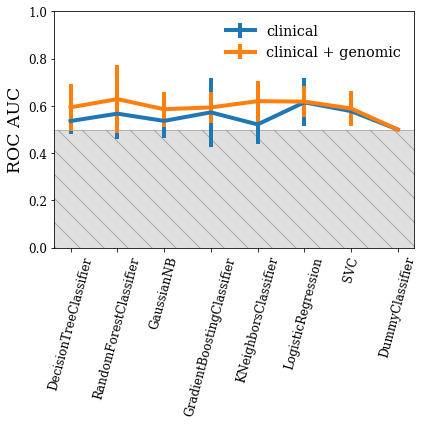

In [33]:
b = b_harmonic_mean

plt.rc('font', family='serif')
fig = plt.figure(figsize=(6, 6))
degrees=75
plt.ylabel('ROC AUC')
plt.xticks(rotation=degrees)
plt.ylim([0, 1])
plt.gca().fill_between([-1, 8], 0, 0.5, facecolor='grey', edgecolor='k', alpha=0.25, hatch='\\')
plt.errorbar(b.index, b['Richard mean'], yerr=b['Richard std'], label='clinical')
plt.errorbar(b.index, b['Freeman mean'], yerr=b['Freeman std'], label='clinical + genomic')
plt.legend(frameon=False)
# plt.tight_layout()
plt.savefig('figs/comparison_classifiers.png', bbox_inches = 'tight')
plt.savefig('figs/comparison_classifiers.eps', bbox_inches = 'tight')

# 4) Choose model logistic regression.
The logistic regression model doesn't have the best accuracy in absolute terms, but is much simpler than the RandomForest. So by occams razor, we pick it.

In [10]:
random_state=1234
logistic_Freeman_parameters = {
    "random_state": random_state,
#     "penalty": "l2",
#     "class_weight": "balanced",
#     "solver": "newton-cg",
#     "C": 1.0,
#     "max_iter": 10000,
#     'tol': 0.00001,
}
logistic_Freeman = pipeline_Freeman(LogisticRegression, **logistic_Freeman_parameters)

# 5) Compare with number of molecules.

In [11]:
# Harmonic mean genomic variable.
X_train_hm_molecules, _ = combine_tsv_files(
    "output/train__harmonic_mean__No. Mutant Molecules per mL.tsv",
    "output/train__harmonic_mean__CNV Score.tsv",
)

In [12]:
# from sklearn.model_selection import cross_val_score
# score_allele_frequency = cross_val_score(logistic_Freeman, X_train_hm, y_train_resp, scoring='roc_auc', cv=5)
# score_molecules = cross_val_score(logistic_Freeman, X_train_hm_molecules, y_train_resp, scoring='roc_auc', cv=5)
# print('Using allele frequency', score_allele_frequency.mean(), '+/-', score_allele_frequency.std())
# print('Using # molecules', score_molecules.mean(), '+/-', score_molecules.std())

# 6) Cross validation
Find the optimal hyper parameters.

In [13]:
logistic_regression_hyper_parameters = {
    "transform_columns__age_discretizer__n_bins": (2, 3, 4, 5),
    "filter_rare_mutations__top_k_features": (4, 5, 6, 7, 8, 10, 12, 18, 24, 48),
#     "estimator__l1_ratio": [0.025, 0.05, 0.125, 0.25, 0.375, 0.5, 0.6, 0.75, 0.85, 1.0],
    "estimator__C": [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0],
    "estimator__class_weight": ["balanced", None],
}
clf_search = GridSearchCV(
    logistic_Freeman,
    logistic_regression_hyper_parameters,
    scoring="roc_auc",
    n_jobs=8,
    cv=5,
)

In [14]:
# clf_search.fit(X_train_hm, y_train_resp)

In [15]:
# print("Best parameters set found on development set:")
# print()
# print(clf_search.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = clf_search.cv_results_['mean_test_score']
# stds = clf_search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf_search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
# print()

In [16]:
# # Non-convergent best parameters under elasticnet.
# best_params = {
#     'estimator__C': 2.0,
#     'estimator__class_weight': None,
#     'estimator__l1_ratio': 0.025,
#     "estimator__penalty": "l1",
#     "estimator__solver": "saga",
#     'filter_rare_mutations__top_k_features': 4,
#     'transform_columns__age_discretizer__n_bins': 2,
# }

# Best parameters under L2 norm.
best_params = {
    "estimator__C": 1.0,
    "estimator__class_weight": "balanced",
    "estimator__solver": "newton-cg",
#     "estimator__solver": "saga",
    "filter_rare_mutations__top_k_features": 4,
#     "transform_columns__age_discretizer__n_bins": 2,
}


In [17]:
# assert best_params == clf_search.best_params_

In [18]:
# Pick the best parameteres.
logistic_Freeman.set_params(**best_params)
logistic_Freeman.fit(X_train_hm, y_train_resp)

Pipeline(memory=None,
         steps=[('clinical_curation',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function clinical_data_curation at 0x7f1c5ef91400>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('remove_specific_phenotypes',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function...
                                                   'adrenalmeta', 'livermeta',
                                                   'lungmeta', 'skeletonmeta',
                                                   'age'])],
                                   verbose=False)),
                ('estimator',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
     

# 7) Make plots of the model

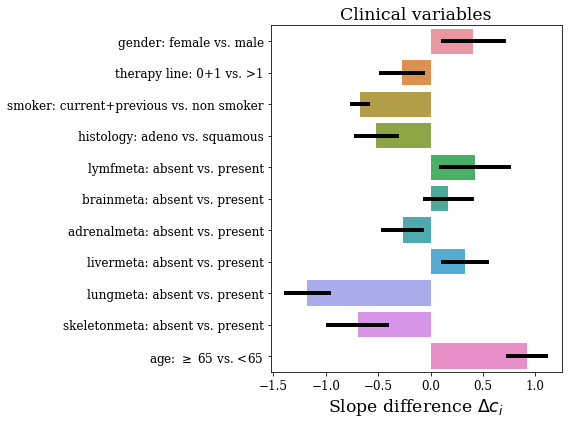

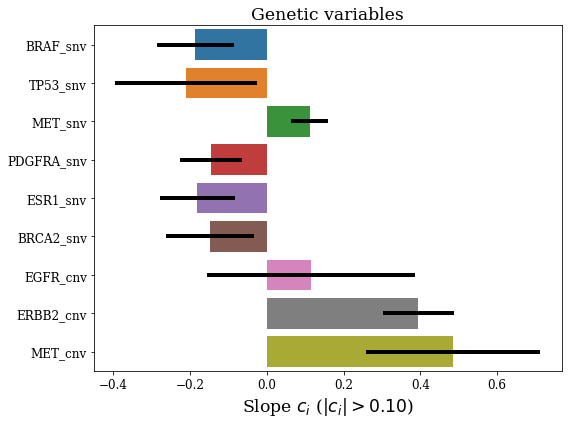

In [19]:
figure_filenames = ("logistic_regression_clinical_freeman", "logistic_regression_genetic_freeman")
view_linear_model_freeman(X_train_hm, y_train_resp, logistic_Freeman, filenames=figure_filenames, thresshold=0.1)